In [ ]:
#FIX DATA GAPS
#CHOOSE TEST DATA WITHIN TRAIN DATA
#RERUN
# SUGGESTIONs FOR DATA: 1.LARGER BINS IN TIME (5 MINS 30 MINS 1 HOURS)
# 2. MEDIAN INSTEAD OF MEAN
# 3. LABELS: NOT ALL FRAMES ACTUALLY HAVE A FACE REGOGNIZED!!! CHECK THE 'SUCCESS' COLUMN (ALREADY THROWN OUT HERE)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from FeatureRelated.feature_generator import Feature_generator
from LabelRelated.label_generator import Label_generator 
import warnings
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import time

In [18]:
#edf_path, emo_path=get_paths(pat_name,sess)
featuregen=Feature_generator('/data2/users/stepeter/Preprocessing/processed_cb46fd46_4.h5', wsize=300)

In [19]:
#TODO don't show pass the mask here, do it somewhere else (Symbiosis class)
#TODO these numbers currently come from handpicking an interval of time that has continuous recordings
#They are considered in featuregen and have to be considered in the labels as well. DO THIS DIFFERENTLY THOUGH
lablegen=Label_generator('/home/emil/data/hdf_data/cb46fd46_8_realtime.csv', wsize=300,start=featuregen.start,stop=featuregen.end)
#lablegen=Label_generator('/home/emil/data/hdf_data/cb46fd46_8_realtime.csv', wsize=1800,start=11,stop=43205)


In [3]:
#print(featuregen.data_bin.shape)
lablegen.pred_bin.shape

(31, 43194)

  0%|          | 0/100 [00:00<?, ?it/s]

Setting up PCA on current data range...


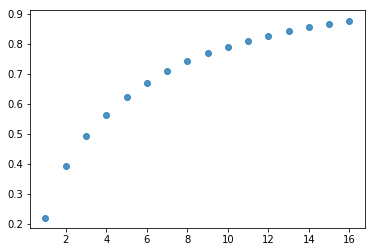

In [20]:
#do simple tr/test linear regression
sliding=False
x=featuregen.generate_features(start=0,end=30000,expl_variance=87,train=True,sliding_window=sliding)

In [26]:
y=lablegen.generate_labels(start=0,end=30000,mask=featuregen.mask_bin, sliding_window=sliding)

In [ ]:
# ##all for debugging purposes
# # df=pd.read_csv('/home/emil/data/hdf_data/cb46fd46_8_realtime.csv',error_bad_lines=False, low_memory=False,parse_dates=['realtime'])

# # df['realtime'][:]

# # som_ob=df['realtime'][1:]-df['realtime'][:-1]
# # som_ob[0]

# # tot=0
# # # for i in range(1,(df.shape[0])):
# # #     if (df.loc[i][-1]-df.loc[i-1][-1]).seconds >0:
# # #         tot=(df.loc[i][-1]-df.loc[i-1][-1]).seconds
# # #         sec= tot/1000
# # #         print('seconds passed since last frame: %d, which was on frame %d' % (tot, i), 'which is at', df.loc[i][-1])
# # tot=0
# # for i in range(1,3481):
# #     if df.loc[i][0]-df.loc[i-1][0] >1:
# #         print('hoppla')
# # tot

# # df['Happy_predicted'].value_counts()

# import h5py
# scrrr=h5py.File('/data2/users/stepeter/Preprocessing/processed_cb46fd46_4.h5')

# scrrr['dataset'].shape[1]/500

In [27]:
print(x.shape)
print(y.shape)

(99, 16)
(100,)


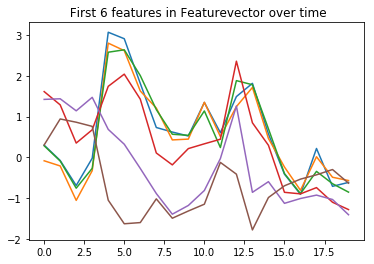

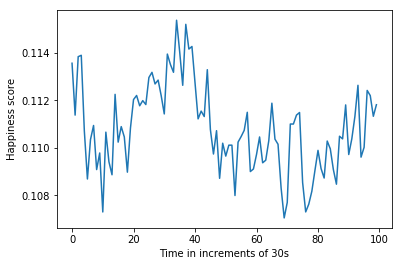

In [23]:
ran=6
for i in range(ran):
    plt.plot(featuregen.curr_data[:20,i])
plt.title(' First %d features in Featurevector over time' % ran)
plt.show()
plt.plot(y)
plt.xlabel('Time in increments of 30s')
plt.ylabel('Happiness score')
plt.show()

In [ ]:
# TODO Median 
#Try median 

In [ ]:
x_ev=featuregen.generate_features(start=36000,end=40000,train=False,sliding_window=sliding)

In [ ]:
y_ev=lablegen.generate_labels(start=36000,end=40000,sliding_window=sliding, mask=featuregen.mask_bin)

In [ ]:
featuregen.mask_bin.shape

In [ ]:
print(y.shape)
print(y_ev.shape)
print(x.shape)
print(x_ev.shape)
#print(y.shape)
lel=(featuregen.mask_bin[:30000].reshape(featuregen.wsize,-1))
print(lel.shape)
lel=np.any(lel,axis=0)
np.unique(lel,return_counts=True)

In [ ]:
#plot different things

featuregen.vis_pc()

featuregen.vis_raw_data(start=36000,stop=40000)

featuregen.curr_data.shape

#Plotting the actual features over time. Here, plot the first five features.
ran=45
for i in range(ran):
    plt.plot(featuregen.curr_data[:,i])
plt.title(' First %f features in Featurevector over time' % ran)
plt.show()
plt.plot(y_ev)
plt.xlabel('Time in increments of 30s')
plt.ylabel('Happiness score')
plt.show()

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn import linear_model

In [ ]:
ols=linear_model.LinearRegression()
ridge=RidgeCV(alphas=np.array([1000000000,100,10000,1000,10,1,.1,]),store_cv_values=True)
#ridge=linear_model.Ridge(alpha=10000)
ols.fit(x,y)
ridge.fit(x,y)

In [ ]:
y_pred_l=ols.predict(x_ev)
y_pred_ridge=ridge.predict(x_ev)

plt.plot(y_pred_l,label='LR Pred')
plt.plot(y_pred_ridge,label='RR Pred')
plt.title('Linear Regression, Ridge regression w/ alpha=%d' % ridge.alpha_)
plt.plot(y_ev,label='Test Data')
plt.legend()
plt.show()

y_tr_pred_l=ols.predict(x)
y_tr_pred_ridge=ridge.predict(x)

plt.plot(y_tr_pred_l[:150],label='LR Pred')
plt.plot(y_tr_pred_ridge[:150],label= 'RR Pred')
plt.title('Linear Regression, Ridge regression w/ alpha=%d' % ridge.alpha_)
plt.plot(y[:150], label='Train Data')
plt.legend()
plt.show()

In [ ]:
print(ridge.cv_values_.shape)
plt.plot(ridge.cv_values_[:,3])
plt.title('Cross Validation MSE, for alpha=%3f'% ridge.alphas[3])
plt.ylabel('MSE')
plt.xlabel('Iteration')

In [ ]:
#try Kernel Ridge
kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1), cv=5,
                  param_grid={"alpha": [1e2,1e4,1e0, 0.1, 1e-2],
                              "gamma": np.logspace(-4, 4, 25)},scoring='neg_mean_squared_error',n_jobs=-1)


kr.fit(x,y)


In [ ]:
al, ga=kr.best_params_.values()
print(al,ga)

In [ ]:
y_kr_pred=kr.predict(x_te)
plt.plot(y_te, label='Test')
plt.plot(y_kr_pred,label='Prediction')
plt.xlabel('time (in 30s window - increments)')
plt.ylabel('Happiness score')
plt.title('Ridge Reg w/ RBF Kernel, gamma=%2f, alpha=%f' %(ga,al))
plt.legend()
plt.show()
y_kr_pred_tr=kr.predict(x_tr)
plt.plot(y_tr, label='Train')
plt.plot(y_kr_pred_tr,label='Prediction')
plt.xlabel('time (in 30s window - increments)')
plt.ylabel('Happiness score')
plt.legend()

In [ ]:
kr.best_estimator_

In [ ]:
kr.cv_results_

In [ ]:
#try poly Ridge
pol = GridSearchCV(KernelRidge(kernel='poly', gamma=0.1), cv=10,
                  param_grid={"alpha": [1e5,1e6,1e3,1e2,1e0,1e-1,1e-2],
                              "degree": np.random.choice(np.arange(1, 60),5, replace=False)},scoring='neg_mean_squared_error',n_jobs=-1)


pol.fit(x_tr,y_tr)

In [ ]:
al, de=pol.best_params_.values()
print(al,de)

In [ ]:
print('Best params',pol.best_params_)
y_pol_pred=pol.predict(x_te)
plt.plot(y_te, label='Test')
plt.plot(y_pol_pred,label='Prediction')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Happiness')
plt.title('Poly Kernel, d=%d, lambda=%1f' %(de,al))
plt.show()
y_pol_pred_tr=pol.predict(x_tr)
plt.plot(y_tr[:150], label='Train')
plt.plot(y_pol_pred_tr[:150],label='Prediction')
plt.legend()

In [ ]:
ranf = GridSearchCV(RandomForestRegressor(), cv=5,
                  param_grid={"max_depth": np.random.choice(np.arange(10,100),20,replace=False),
                              "n_estimators": np.random.choice(np.arange(10,100),20,replace=False)},scoring='neg_mean_squared_error',n_jobs=-1)
ranf.fit(x_tr,y_tr)

In [ ]:
print('Best params',ranf.best_params_)
y_ranf_pred=ranf.predict(x_te)
plt.plot(y_te, label='Test')
plt.plot(y_ranf_pred,label='Prediction')
plt.legend()
plt.show()
y_ranf_pred_tr=ranf.predict(x_tr)
plt.plot(y_tr[:200], label='Train')
plt.plot(y_ranf_pred_tr[:200],label='Prediction')
plt.legend()

In [ ]:
plt.plot(np.dot(featuregen.curr_data,featuregen.pca.components_.T))
plt.xlabel('Time (in w_size)')
plt.ylabel('PC Value')
plt.title('First %d principal components' % featuregen.pca.n_components)
plt.show()


In [ ]:
plt.plot(x_tr)


In [ ]:
reconstr=np.dot(x_tr ,featuregen.pca.components_)

In [ ]:
fig = plt.figure(figsize=(15,15))
plt.imshow(reconstr,cmap='plasma')

In [ ]:
#fig = plt.figure(figsize=(15,15))
plt.imshow(x_tr[:250].T,vmin=np.min(x_tr),vmax=np.max(x_tr))
print(np.mean(x_tr))
plt.show()
plt.plot(y_tr)
chans=np.arange(4,20)
data=featuregen.data[chans,0:30000]
for p in range(0,len(chans)-1):
    plt.plot(data[p])
plt.xlabel('No. Samples (500Hz sample freq.)')
plt.ylabel('mV')
plt.show()

In [ ]:
featuregen.curr_data.shape

In [ ]:
rem=featuregen.curr_data[:].T
plt.imshow(rem,cmap='plasma',aspect='auto')
plt.xlabel('Time in 30s increments')
plt.gca().invert_yaxis()
plt.ylabel('Chans x Bins')


In [ ]:
np.unique(featuregen.bad_idx,return_counts=True)

In [ ]:
#     #create
#     #edf_path, emo_path=get_paths(pat_name,sess)
#     featuregen=Feature_generator('/data2/users/stepeter/Preprocessing/Reref/processed_cb46fd46_4.h5')
#     #TODO this part
#     lablegen=Label_generator('/home/emil/data/hdf_data/cb46fd46_8_realtime.csv')
# def get_paths(pat_name,sess):
#     #path for preprocessed edf data. THIS ASSUMES CODE IS RUN ON CYLON
#     edf_path=os.path.join(os.path.sep,'/data2/users/stepeter/Preprocessing/Reref','preprocessed_'+pat_name+'_'+sess+'.h5')
#     #path for emo annotations. THIS ASSUMES CODE IS WHERE THIS LINKS,
#     emo_path=os.path.join(os.path.sep,'/home/emil/data/hdf_data',pat_name+'_'+sess+'.h5')
#     #path for video discontinuity TODO actually do this
#     disc_path=os.path.join(os.path.sep,'/home/emil/data/sync_data',pat_name+'_'+sess+'.txt')

# #most definitely needed
# #TODO: DO THIS CORRECTLY. for now use bad hack
# def sync(self):
#     #when does video start
#     ec_st=ecog.start_time
#     em_st=emo.df['realtime'].loc[0]
#     #first, we want to ensure that the first label comes NOT BEFORE the first ecog sample
#     if(ec_st>em_st):
#         em_st=em_st+((ec_st-em_st)//32)*(32+1)
#     #next, edge as close as possible to first label time
#     ec_st=ec_st+((em_st-ec_st)//500)*500
#     return em_st,ec_st


    

In [ ]:
#try classification:
#SVC
from sklearn import svm

# kernel_svm = svm.SVC(gamma=.2)
# linear_svm = svm.LinearSVC()

# kernel_svm.fit(x_tr,y_tr)
# linear_svm.fit(x_tr,y_tr)

In [ ]:
print(kernel_svm.score(x_te,y_te))
print(linear_svm.score(x_te,y_te))

In [ ]:
print(kernel_svm.score(x_tr,y_tr))
print(linear_svm.score(x_tr,y_tr))

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=15)

for gamma in np.random.choice(np.arange(1,20),15,replace=False):
    tprs = []
    aucs = []
    scores=[]
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    classifier = svm.SVC(kernel='poly', probability=True,degree=gamma)
    for train, test in cv.split(x, y[:-2]):
        print('aight, gamma=%d, iter=%d' % (gamma,i))
        probas_ = classifier.fit(x[train], y[train]).predict_proba(x[test])
        scores+=[classifier.score(x[train], y[train])]

        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plt.plot(fpr, tpr, lw=1, alpha=0.3,
        #         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for SVC w/ RBF kernel, d=%2d' %gamma)
    plt.legend(loc="lower right")
    plt.show()
    
    plt.plot(np.arange(len(scores)),scores)
    plt.xlabel('CV Iteration')
    plt.ylabel('Accuracy')
    plt.title('SVC with poly kernel,d=%2d' % gamma)
    plt.ylim([0.91,0.93])
    plt.show()


In [ ]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=15)
classifier = svm.SVC(kernel='linear', probability=True)

tprs = []
aucs = []
scores=[]
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x, y[:-2]):
    probas_ = classifier.fit(x[train], y[train]).predict_proba(x[test])
    scores+=[classifier.score(x[train], y[train])]
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,
    #         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SVC w/ linear kernel')
plt.legend(loc=(1.04,0))
plt.show()


In [ ]:
plt.plot(np.arange(len(scores)),scores)
plt.xlabel('CV Iteration')
plt.ylabel('Accuracy')
plt.title('SVC with linear kernel')
plt.ylim([0.91,0.93])

In [ ]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=15)
classifier = svm.SVC(kernel='poly', probability=True,degree=4)

tprs = []
aucs = []
scores=[]
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(x, y[:-2]):
    probas_ = classifier.fit(x[train], y[train]).predict_proba(x[test])
    scores+=[classifier.score(x[train], y[train])]
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    #plt.plot(fpr, tpr, lw=1, alpha=0.3,
    #         label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for SVC w/ linear kernel')
plt.legend(loc=(1.04,0))
plt.show()
